In [18]:
import matplotlib.pyplot as plt
import numpy as np
import classy

from astropy.cosmology import Planck18_arXiv_v2 as Planck

h = Planck.h
class LCDM:
    h = h
    H0 = Planck.H0.value
    omega_b = Planck.Ob0 * h ** 2
    omega_cdm = (Planck.Om0 - Planck.Ob0) * h ** 2
    omega_nu = Planck.Onu0
    omega_k = Planck.Ok0

    m_ncdm = sum(Planck.m_nu).value
    Neff = Planck.Neff
    N_ncdm = 1
    N_ur = Planck.Neff - N_ncdm

    Tcmb = Planck.Tcmb0.value
    A_s = 2.097e-9
    tau_reio = 0.0540
    n_s = 0.9652
    YHe = 0.24537116583825905
    reion_exponent = 1.5
    reion_width = 0.5

    @classmethod
    def class_params(self):
        return {
            'h': self.h, 'omega_b': self.omega_b, 'omega_cdm': self.omega_cdm,
            'Omega_k': self.omega_k, 'N_ur': self.N_ur, 'N_ncdm': self.N_ncdm,
            'm_ncdm': self.m_ncdm, 'A_s': self.A_s, 'n_s': self.n_s,
            'T_cmb': self.Tcmb, 'tau_reio': self.tau_reio, 'YHe': self.YHe,
            'reionization_exponent': self.reion_exponent,
            'reionization_width': self.reion_width, 'P_k_max_1/Mpc': 200,
            'output': 'dTk,mPk,tCl',
        }



In [19]:
m_dmeff = 1.0  # GeV
sigma_dmeff = 1e-41  # cm^2
Vrel_dmeff = 30 # km/s at z ~ 1010
params = LCDM.class_params()
# params.update({
#     'omega_dmeff': 0.12038, 'omega_cdm': 1e-10, 'm_dmeff': m_dmeff,
#     'sigma_dmeff': sigma_dmeff, 'npow_dmeff': -4, 'Vrel_dmeff': Vrel_dmeff
# })
z_pk = 60.
params.update({'z_pk': z_pk})

cl = classy.Class()
cl.set(params)
cl.compute()

In [5]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c=params['omega_cdm'], 
                      Omega_b=params['omega_b'],
                      h=params['h'],
                      n_s=params['n_s'], A_s=params['A_s'])

In [16]:
# adapting from here: https://github.com/damonge/ShCl_like/blob/0350b0cca5de51cd92efb8e27be292bbbb449bce/shcl_like/clccl.py#L141
z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))

a = 1/(1 + z_bg[::-1])
distance = cl.z_of_r(z_bg)
distance = np.flip(distance)

hubble_z = np.array([cl.Hubble(z) for z in z_bg])
H0 = hubble_z[0]
E_of_z = hubble_z / H0
E_of_z = np.flip(E_of_z)

kmax = 100
k_arr = np.logspace(-5, 2, 1000)
z_pk = np.array([60.,])
class_pk_lin = cl.get_pk_array(k_arr, z_pk, 1000, 1, False)

cosmo._set_background_from_arrays(a_array=a, chi_array=distance, hoh0_array=E_of_z)

cosmo._set_linear_power_from_arrays(1./(1 + z_pk), k_arr, class_pk_lin)

In [20]:
class_pk_lin

array([8.99757999e-02, 9.13879337e-02, 9.28222303e-02, 9.42790373e-02,
       9.57587082e-02, 9.72616017e-02, 9.87880822e-02, 1.00338520e-01,
       1.01913291e-01, 1.03512777e-01, 1.05137367e-01, 1.06787453e-01,
       1.08463436e-01, 1.10165723e-01, 1.11894727e-01, 1.13650865e-01,
       1.15434566e-01, 1.17246260e-01, 1.19086388e-01, 1.20955396e-01,
       1.22853736e-01, 1.24781870e-01, 1.26740264e-01, 1.28729394e-01,
       1.30749742e-01, 1.32801798e-01, 1.34886060e-01, 1.37003032e-01,
       1.39153229e-01, 1.41337172e-01, 1.43555390e-01, 1.45808421e-01,
       1.48096812e-01, 1.50421117e-01, 1.52781901e-01, 1.55179735e-01,
       1.57615200e-01, 1.60088889e-01, 1.62601400e-01, 1.65153342e-01,
       1.67745335e-01, 1.70378006e-01, 1.73051995e-01, 1.75767949e-01,
       1.78526528e-01, 1.81328400e-01, 1.84174244e-01, 1.87064750e-01,
       1.90000620e-01, 1.92982565e-01, 1.96011309e-01, 1.99087585e-01,
       2.02212140e-01, 2.05385730e-01, 2.08609127e-01, 2.11883111e-01,
      

In [17]:
mdef = ccl.halos.MassDef(500, 'critical')
hmf = ccl.halos.MassFuncTinker08(cosmo, mass_def=mdef)

CCLError: Error CCL_ERROR_MEMORY: 

In [6]:
import numpy as np
Mgrid = np.logspace(6, 12, 100)

def z_to_a(z):
    return 1 / (1 + z)

dndm = hmf.get_mass_function(cosmo, Mgrid, z_to_a(60))

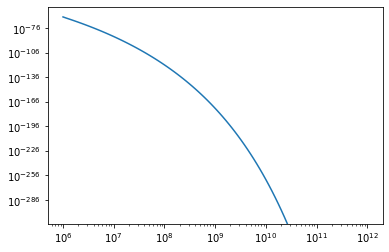

In [7]:
import matplotlib.pyplot as plt

plt.loglog(Mgrid, dndm)